In [1]:
import os
os.chdir("..")
import random
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
%load_ext autoreload
%autoreload 2

# Utility Functions

In [2]:
def generate_linear_example(samples=int(1e5)):
    x_data = np.random.sample(samples)[:, np.newaxis].astype(np.float32)
    y_data = np.add(5*x_data, np.multiply((x_data)**2, np.random.standard_normal(x_data.shape)))

    x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.5, random_state=42)
    x_test = np.linspace(0.,1.,int(1e3))[:, np.newaxis].astype(np.float32)
    df_train = pd.DataFrame({"col1": x_train.ravel(), "target": y_train.ravel()})
    df_valid = pd.DataFrame({"col1": x_valid.ravel(), "target": y_valid.ravel()})
    # test = sorted(df_valid.col1.round(3).unique())
    # df_test = pd.DataFrame({"col1": test})
    df_test = pd.DataFrame({"col1": x_test.ravel()})
    return (df_train, df_valid, df_test, ["target"])

def print_metrics(y_true, y_pred, tag):
    if isinstance(y_true, pd.DataFrame) or isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame) or isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    if y_true.ndim>1:
        y_true=y_true.ravel()
    if y_pred.ndim>1:
        y_pred=y_pred.ravel()
    val_acc = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred)
    print(f"{tag} Acc: {val_acc} | {tag} F1: {val_f1}")

# Generate Synthetic Data 

First of all, let's create a synthetic data which is a mix of numerical and categorical features

In [3]:
df_train, df_valid, df_test, target_col = generate_linear_example()

## Plot

In [4]:
from IPython.core.display import display, HTML, Math

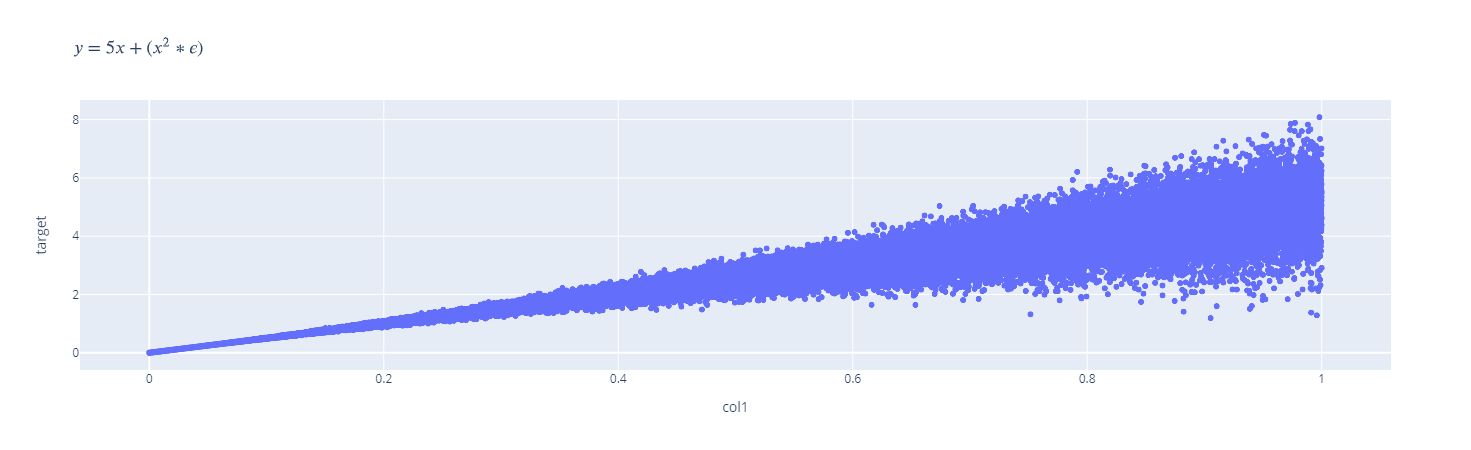

In [5]:
# display(Math(r"$y = 5x + (x^2 * \epsilon)$"+"\n"+r"$\epsilon \backsim \mathcal{N}(0,1)$"))
fig = px.scatter(df_train, x="col1", y="target", title=r"$y = 5x + (x^2 * \epsilon)$"+"\n"+r"$\epsilon \backsim \mathcal{N}(0,1)$")
fig

# Importing the Library

In [6]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import (
    CategoryEmbeddingModelConfig,
    NodeConfig,
    TabNetModelConfig,
    CategoryEmbeddingMDNConfig,
    MixtureDensityHeadConfig,
    NODEMDNConfig,
)
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
    ExperimentConfig,
)
from pytorch_tabular.categorical_encoders import CategoricalEmbeddingTransformer

## Define the Configs

In [11]:
epochs = 15
batch_size = 128
steps_per_epoch = int((len(df_train)//batch_size)*0.9)
data_config = DataConfig(
    target=['target'],
    continuous_cols=['col1'],
    categorical_cols=[],
#         continuous_feature_transform="quantile_uniform"
)
trainer_config = TrainerConfig(
    auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=batch_size,
    max_epochs=epochs,
    early_stopping_patience = 5,
    gpus=1, #index of the GPU to use. 0, means CPU
)
# optimizer_config = OptimizerConfig(lr_scheduler="OneCycleLR", lr_scheduler_params={"max_lr":0.005, "epochs": epochs, "steps_per_epoch":steps_per_epoch})
optimizer_config = OptimizerConfig(lr_scheduler="ReduceLROnPlateau", lr_scheduler_params={"patience":3})
mdn_config = MixtureDensityHeadConfig(num_gaussian=1)
model_config = CategoryEmbeddingMDNConfig(
    task="regression",
    mdn_config=mdn_config,
    layers="128-64",  # Number of nodes in each layer
    activation="ReLU",  # Activation between each layers
    learning_rate=1e-3,
    batch_norm_continuous_input=True,
    use_batch_norm=True,
    dropout=0.0,
    embedding_dropout=0,
    initialization="kaiming",
    #         target_range=[(df_train[col].min(),df_train[col].max()) for col in ['target']]
)
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config
)

## Training the Model 

In [12]:
tabular_model.fit(train=df_train, validation=df_valid)

d:\playground\tabular\pytorch-tabular\env\lib\site-packages\pytorch_lightning-1.1.0-py3.8.egg\pytorch_lightning\utilities\distributed.py:49: UserWarning:

Checkpoint directory saved_models exists and is not empty. With save_top_k=1, all files in this directory will be deleted when a checkpoint is saved!

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
d:\playground\tabular\pytorch-tabular\env\lib\site-packages\pytorch_lightning-1.1.0-py3.8.egg\pytorch_lightning\utilities\distributed.py:49: UserWarning:

GPU available but not used. Set the --gpus flag when calling the script.

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                | Params
---------------------------------------------------------------
0 | embedding_layers       | ModuleList          | 0     
1 | normalizing_batch_norm | BatchNorm1d         | 2     
2 | backbone               | FeedForwar

LR finder stopped early due to diverging loss.
Learning rate set to 0.0007585775750291836

  | Name                   | Type                | Params
---------------------------------------------------------------
0 | embedding_layers       | ModuleList          | 0     
1 | normalizing_batch_norm | BatchNorm1d         | 2     
2 | backbone               | FeedForwardBackbone | 8.8 K 
3 | mdn                    | MixtureDensityHead  | 194   
4 | loss                   | MSELoss             | 0     
---------------------------------------------------------------
9.0 K     Trainable params
0         Non-trainable params
9.0 K     Total params


In [13]:
pred_df = tabular_model.predict(df_test, quantiles=[0.25,0.5,0.75], n_samples=100)
pred_df.head()

col1  target_prediction  target_q25  target_q50  target_q75
0  0.000000           0.557552    0.034879    0.529242    1.042608
1  0.001001           0.491563    0.060616    0.464388    0.941083
2  0.002002           0.470586    0.050584    0.462707    0.815913
3  0.003003           0.458056    0.066159    0.482623    0.892413
4  0.004004           0.430301    0.036575    0.387163    0.861861

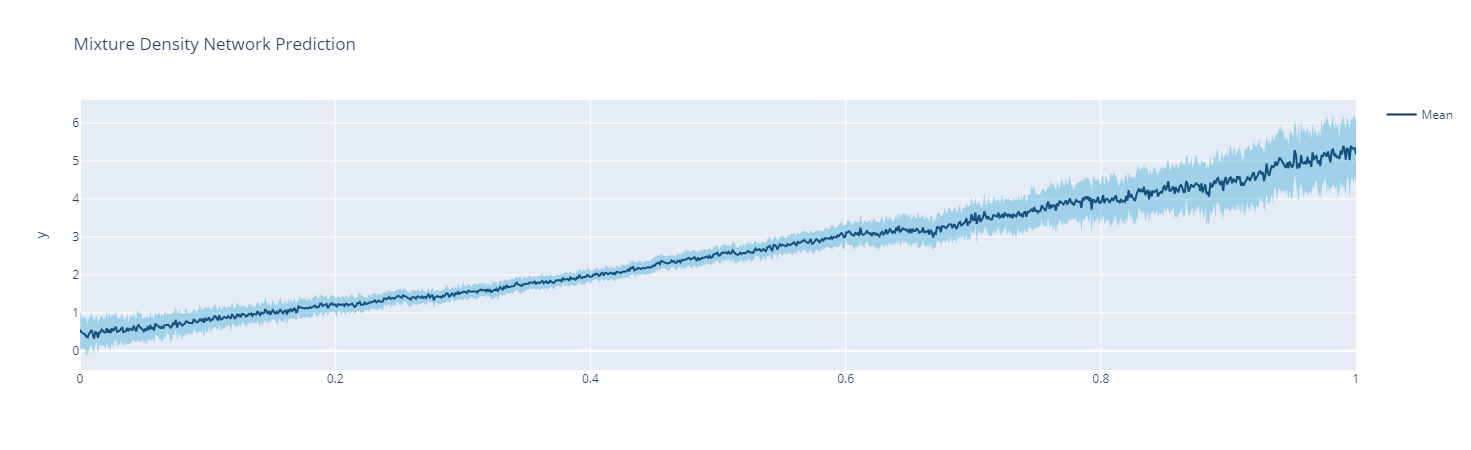

In [14]:
fig = go.Figure([
    go.Scatter(
        name='Mean',
        x=pred_df['col1'],
        y=pred_df['target_prediction'],
        mode='lines',
        line=dict(color='rgba(28,53,94,1)'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=pred_df['col1'],
        y=pred_df['target_q75'],
        mode='lines',
        marker=dict(color='rgba(0,147,201,0.3)'),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=pred_df['col1'],
        y=pred_df['target_q25'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(0,147,201,0.3)',
        fill='tonexty',
        showlegend=False
    )
])
fig.update_layout(
    yaxis_title='y',
    title='Mixture Density Network Prediction',
    hovermode="x"
)
fig.show()